In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '15644' (I am process '14820')
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpmw8fyp/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpmw8fyp/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
data1=trX
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [17]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

# def batchnorm( x, g=None, b=None, eps=1e-8 ):
#     if x.ndim == 4:
#         m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
#         v = tensor.mean(tensor.sqr(x - m), 
#                           axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

#     elif x.ndim == 2:
#         m = tensor.mean(x, axis=0)
#         v = tensor.mean(tensor.sqr(x - m), axis=0)

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g + b

#     return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

def rnd_categorical(n, n_categorical):
    indices = np.random.randint(n_categorical, size=n)
    one_hot = np.zeros((n, n_categorical))
    one_hot[np.arange(n), indices] = 1
    return one_hot, indices
def rnd_continuous(n, n_continuous, mu=0, std=1):
    return np.random.normal(mu, std, size=(n, n_continuous))

In [36]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout, batchnorm
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 30          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 40          # # of gen filters in first conv layer
ndf = 40          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 0 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
n_categorical = 10
n_continuous =2
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
#ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#generator
gw  = gifn((nz, ngf*8*4*4), 'gw')
gg = gain_ifn((ngf*8*4*4), 'gg')
gb = bias_ifn((ngf*8*4*4), 'gb')
gw2 = gifn((ngf*8, ngf*4, 5, 5), 'gw2')
gg2 = gain_ifn((ngf*4), 'gg2')
gb2 = bias_ifn((ngf*4), 'gb2')
gw3 = gifn((ngf*4, ngf*2, 5, 5), 'gw3')
gg3 = gain_ifn((ngf*2), 'gg3')
gb3 = bias_ifn((ngf*2), 'gb3')
gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
gg4 = gain_ifn((ngf), 'gg4')
gb4 = bias_ifn((ngf), 'gb4')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

#discriminator
dw  = difn((ndf, nc, 5, 5), 'dw')
dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')
dw3 = difn((ndf*4, ndf*2, 5, 5), 'dw3')
dg3 = gain_ifn((ndf*4), 'dg3')
db3 = bias_ifn((ndf*4), 'db3')
dw4 = difn((ndf*8, ndf*4, 5, 5), 'dw4')
dg4 = gain_ifn((ndf*8), 'dg4')
db4 = bias_ifn((ndf*8), 'db4')
dwy = difn((ndf*8*4*4, 1), 'dwy')
wdd = difn((ndf*8*4*4, 2), 'wdd')
bdd = bias_ifn((2), 'bdd')

gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gw4, gg4, gb4, gwx]
discrim_params = [dw, dw2, dg2, db2, dw3, dg3, db3, dw4, dg4, db4, dwy, wdd, bdd]

def gen(Z, w, g, b, w2, g2, b2, w3, g3, b3, w4, g4, b4, wx):
    h = relu(batchnorm(T.dot(Z, w), g=g, b=b))
    h = h.reshape((h.shape[0], ngf*8, 4, 4))
    h2 = relu(batchnorm(deconv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    x = sigmoid(deconv(h4, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def discriminator(X, w, w2, g2, b2, w3, g3, b3, w4, g4, b4, wy, wdd, bdd):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = lrelu(batchnorm(dnn_conv(h2, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    h4 = lrelu(batchnorm(dnn_conv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    h4 = T.flatten(h4, 2)
    d = lrelu( full_conn( h4, wdd, bdd ) )
    y = sigmoid(T.dot(h4, wy))
    return d, y

# prepare for model
X = T.tensor4()
Z = T.matrix()

x_fake = gen(Z, *gen_params)
y_fake, mi = discriminator(x_fake, *discrim_params)
y_real, _ = discriminator(X, *discrim_params)

#mi_categorical, mi_continuous_mean=theano.tensor.split(mi, [10, 2], 2, axis=1)

generator_loss = bce(y_fake, T.ones(nbatch)).mean()
discriminator_loss = bce(y_fake, T.zeros(nbatch)).mean()
#discriminator_loss += bce(y_real, T.ones(nbatch)).mean()

# #mi_categorical=T.matrix('mi_categorical')
# #categories = T.ivector('categories')

# c_categorical, categories = rnd_categorical(nbatch, n_categorical)
# categorical_loss = bce(mi_categorical, categories).mean()

# # Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
# mi_continuous_ln_var = np.empty_like(mi_continuous_mean)
# mi_continuous_ln_var.fill(1)
# # mi_continuous_ln_var.fill(1e-6)
# from chainer import functions as F
# from chainer import Variable
# c_continuous = np.asarray(rnd_continuous(nbatch, n_continuous))
# #continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
# #continuous_loss /= nbatch
        
# generator_loss += categorical_loss
# #generator_loss += continuous_loss

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, discriminator_loss)
g_updates = g_updater(gen_params, generator_loss)

print 'COMPILING......'
t = time()
_train_g = theano.function([Z], cost, updates=generator_loss)
_train_d = theano.function([X, Z], cost, updates=discriminator_loss)
_gen = theano.function([Z], gX)

# for epoch in range(max_epochs):
#     generator_epoch_loss = np.float32(0)
#     discriminator_epoch_loss = np.float32(0)
#     for i in range(0, len(trX), nbatch):
#         zs = np_rng.uniform(-1, 1, (nbatch, nz)).astype(np.float32)
#         c_categorical, categories = rnd_categorical(nbatch, n_categorical=10)
#         c_categorical = np.asarray(c_categorical, dtype=np.float32)
#         categories = np.asarray(categories, dtype=xp.int32)
#         # Sample continuous codes to learn rotation, thickness, etc.
#         c_continuous = np.asarray(rnd_continuous(nbatch, n_continuous=2), dtype=xp.float32)
#         zc = np.concatenate((zs, c_categorical, c_continuous), axis=1)
#         # Forward
#         x_fake = gen(zc,*gen_params)
#         y_fake, mi = discrim(x_fake,*dis_params)

#         x_real = np.zeros((batch_size, npx, npx), dtype=np.float32)
#         for xi in range(len(x_real)):
#             x_real[xi] = xp.array(train[np.random.randint(train_size)])
#         x_real = np.expand_dims(x_real, 1)
#         y_real, _ = discriminator(x_real)
#         # Losses
#         generator_loss = bce(y_fake, np.ones(nbatch, dtype=xp.int32))
#         discriminator_loss = bce(y_fake, np.zeros(nbatch, dtype=np.int32))
#         discriminator_loss += bce(y_real, np.ones(nbatch, dtype=np.int32))
        
#         # Mutual Information loss
#         mi_categorical, mi_continuous_mean = F.split_axis(mi, [n_categorical], 1)
        
#         # Categorical loss
#         categorical_loss = bce(mi_categorical, categories, use_cudnn=False)  
        
#         # Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
#         mi_continuous_ln_var = np.empty_like(mi_continuous_mean.data, dtype=xp.float32)
#         mi_continuous_ln_var.fill(1)
#         # mi_continuous_ln_var.fill(1e-6)
#         continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
#         continuous_loss /= nbatch
        
#         generator_loss += categorical_loss
#         generator_loss += continuous_loss
#         # Backprop
#         cost = _train_g(imb, zmb)

DisconnectedInputError: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: dwy
Backtrace when the node is created:
  File "c:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "c:\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-f1840b183ed7>", line 108, in <module>
    dwy = difn((ndf*8*4*4, 1), 'dwy')
  File "lib\inits.py", line 23, in __call__
    return sharedX(np_rng.normal(loc=self.loc, scale=self.scale, size=shape), name=name)
  File "lib\theano_utils.py", line 11, in sharedX
    return theano.shared(np.asarray(X, dtype=dtype), name=name)


In [ ]:
x_fake = gen(Z, *gen_params)
y_fake, mi = discriminator(x_fake, *dis_params)
y_real, _ = discriminator(X)

mi_categorical, mi_continuous_mean=theano.tensor.split(mi, [10, 2], 2, axis=1)

generator_loss = bce(y_fake, np.ones(nbatch, dtype=xp.int32))
discriminator_loss = bce(y_fake, np.zeros(nbatch, dtype=np.int32))
discriminator_loss += bce(y_real, np.ones(nbatch, dtype=np.int32))

#mi_categorical=T.matrix('mi_categorical')
#categories = T.ivector('categories')

c_categorical, categories = rnd_categorical(nbatch, n_categorical)
categorical_loss = bce(mi_categorical, categories)

# Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
mi_continuous_ln_var = np.empty_like(mi_continuous_mean.data, dtype=xp.float32)
mi_continuous_ln_var.fill(1)
# mi_continuous_ln_var.fill(1e-6)
continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
continuous_loss /= nbatch
        
generator_loss += categorical_loss
generator_loss += continuous_loss

In [66]:
X=random((2.,2.))
np.empty_like(X.data)

NameError: name 'random' is not defined

In [13]:
from chainer import functions as F


In [ ]:
X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
#updates = d_updates + g_updates

print 'COMPILING......'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)


#sample_zmb = floatX(np_rng.uniform(-1., 1., size=(nvis, nz)))

vaX = vaX.reshape(len(vaX), -1)    

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
vae_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'

In [8]:
for epoch in range(1,2*niter):
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    if (epoch) % 10 == 0:
        print '%.0f %.4f %.4f'%(epoch, g_cost, d_cost)
#     if n_epochs > niter:
#         lrt.set_value(floatX(lrt.get_value() - lr/niter_decay))

10 3.8646 0.0379
20 15.5308 0.0735
30 4.1780 0.0317
40 5.2775 0.0215
50 0.3168 1.5565
60 3.3556 0.0728
70 5.1890 0.0207
80 5.1210 0.0163
90 4.7656 0.0138
100 4.8195 0.0182
110 5.4364 0.0131
120 6.3324 0.0073
130 6.5286 0.0084
140 4.8244 0.0148
150 6.0400 0.0177
160 5.0392 0.0316
170 9.8999 0.1752
180 4.3221 0.0433
190 5.4164 0.0160
200 4.8232 0.0152
210 4.3912 0.0201
220 5.5030 0.0131
230 5.8958 0.0091
240 7.2291 0.0030
250 5.6208 0.0055
260 6.5353 0.0021
270 7.5898 0.0031
280 6.5208 0.0046
290 6.1522 0.0045
300 7.1656 0.0027
310 7.1177 0.0032
320 7.8245 0.0032
330 8.3602 0.0027
340 7.7418 0.0033
350 4.5946 0.0149
360 7.2342 0.0023
370 6.5427 0.0025
380 5.7208 0.0051
390 8.4823 0.0008
400 8.6615 0.0019
410 7.1320 0.0018
420 8.9857 0.0013
430 7.4376 0.0019
440 7.2294 0.0020
450 6.9229 0.0026
460 6.8551 0.0019
470 6.2428 0.0033
480 9.9240 0.0011
490 8.5836 0.0008
500 7.7204 0.0013
510 8.4143 0.0005
520 6.9565 0.0014
530 7.4638 0.0010
540 9.0764 0.0003
550 7.1962 0.0010
560 9.0531 0.0002


KeyboardInterrupt: 

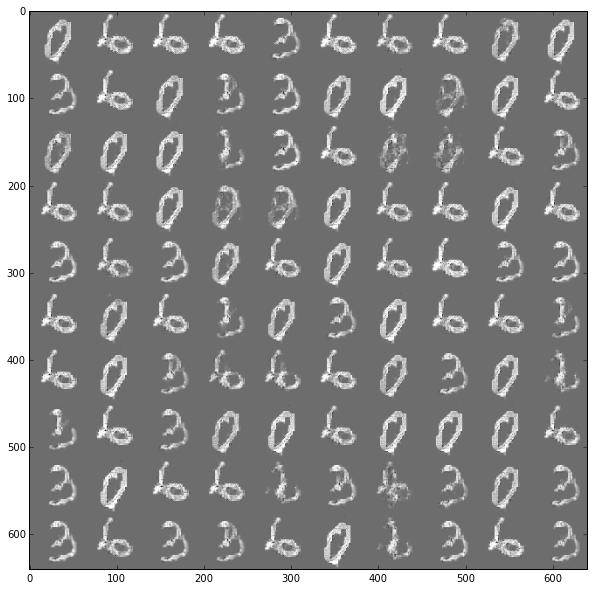

In [18]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()